In [2]:
from scipy.fftpack import dct, idct
import numpy as np
import cv2
from PIL import Image
from glob import glob
import os
from pyiqa import create_metric
import pyiqa
from tqdm import tqdm
import csv
from PIL import Image
import os
import pandas as pd
from pathlib import Path
import sys
sys.path.append('../code/')
from utils import calculate_correctness

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


/home/jcardenuto/miniconda3/envs/iqa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
iqa_df = pd.read_csv("../results/iqa_results_with_arrows.csv")

low = iqa_df[iqa_df["labeled_quality"] == "low"]
mid = iqa_df[iqa_df["labeled_quality"] == "mid"]
high = iqa_df[iqa_df["labeled_quality"] == "high"]
iqa_df = pd.concat([low, mid, high], ignore_index=True)
iqa_df = iqa_df.rename(columns={'pred_compression ↓': "Compression ↓", 'pred_pixelation ↓': "Pixelation ↓"})

In [20]:
def get_best_threshold(model, plot=False):
    low = iqa_df[iqa_df["labeled_quality"] == "low"]
    high = iqa_df[iqa_df["labeled_quality"] == "high"]
    data = pd.concat([low, high], ignore_index=True)
    # make low quality as 0
    data["labeled_quality"] = data["labeled_quality"].apply(lambda x: 0 if x == "low" else 1)
    labels = data["labeled_quality"].values.tolist()
    y = data[model].values.tolist()
    if '↓' in model:
        y = [-x for x in y]
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, y)

    # auc
    roc_auc = auc(fpr, tpr)

    # Find the optimal threshold (maximizing tpr - fpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    if plot:
        # Plot ROC curve
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
    if '↓' in model:
        optimal_threshold = -optimal_threshold
    return optimal_threshold, roc_auc


## AUC Analysis

In [4]:
metrics =  iqa_df.columns[3:]
aucs = []
thresholds = []
for metric in metrics:
    threshold, auc_score = get_best_threshold(metric)
    aucs.append(auc_score)
    thresholds.append(threshold)
# create auc dataframe
auc_df = pd.DataFrame({"metric": metrics, "auc": aucs, "threshold": thresholds})

In [5]:
# remove arrows from metric names
auc_df["metric"] = auc_df["metric"].apply(lambda x: x.replace("↓", ""))
auc_df["metric"] = auc_df["metric"].apply(lambda x: x.replace("↑" , ""))

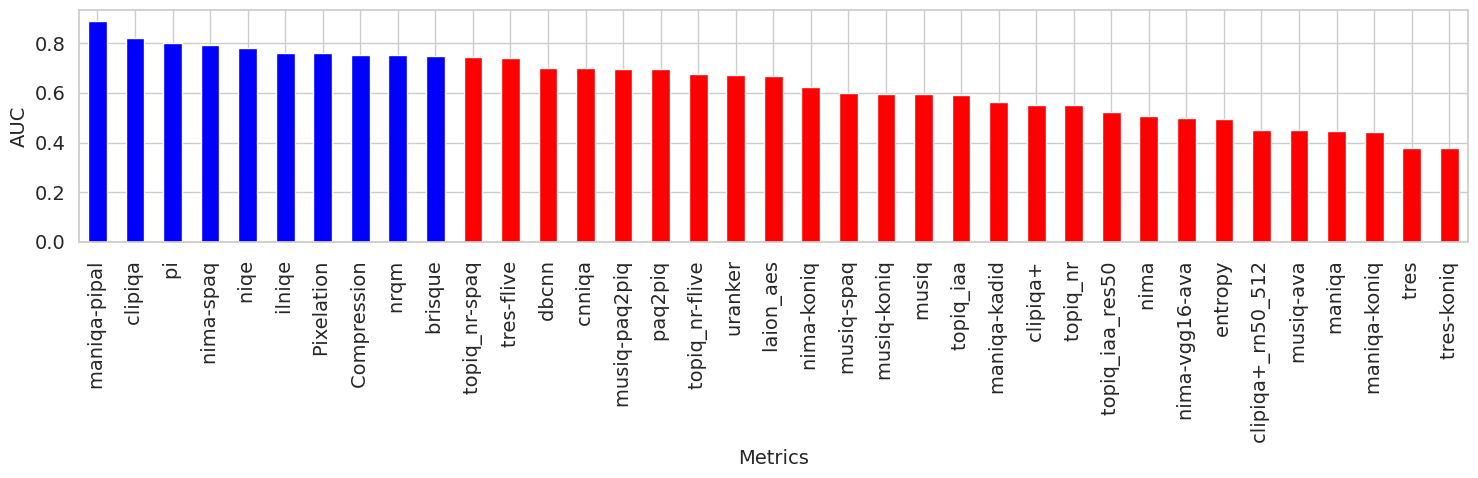

In [6]:
# Plot auc for each metric
# sns settings
fontsize =14
sns.set(rc={'figure.figsize':(15, 5), 'font.size':fontsize, 'axes.titlesize':fontsize, 'axes.labelsize':fontsize, 'xtick.labelsize':fontsize, 'ytick.labelsize':fontsize, 'legend.fontsize':fontsize, 'legend.title_fontsize':fontsize})
sns.set_style('whitegrid')

# Plot top 10 metrics in blue and the rest in red
auc_df.sort_values(by="auc", ascending=False, inplace=True)
colors = ["blue" if x in auc_df["metric"].values[:10] else "red" for x in auc_df["metric"].values]
auc_df.sort_values(by="auc", ascending=False).plot(kind="bar", x="metric", y="auc", legend=False, color=colors, ylabel="AUC", xlabel="Metrics")
# make high quality blue, mid yellow and low red
# change name of the legend to Quality
# plt.legend(title="AUC", loc="upper left")
plt.tight_layout()
plt.savefig("../results/auc/iqa_auc.pdf", dpi=100)

## Correlation Analysis

In [7]:
metrics =  iqa_df.columns[3:]
aucs = []
thresholds = []
for metric in metrics:
    threshold, auc_score = get_best_threshold(metric)
    aucs.append(auc_score)
    thresholds.append(threshold)
# create auc dataframe
auc_df = pd.DataFrame({"metric": metrics, "auc": aucs, "threshold": thresholds})
top_ten = auc_df.sort_values(by="auc", ascending=False).head(10)

In [26]:
hits_df =  iqa_df.iloc[:, 2:].copy()
# drop all columns not in metrics
hits_df = hits_df.drop(columns=[col for col in hits_df.columns if (col not in top_ten["metric"].values) and (col!="labeled_quality")])
for _, row in top_ten.iterrows():
    metric = row["metric"]
    threshold = row["threshold"]
    low_index = hits_df[hits_df["labeled_quality"] == "low"].index
    high_index = hits_df[hits_df["labeled_quality"] == "high"].index

    if "↓" in metric:
        hits_df.loc[low_index, metric] = hits_df[metric].apply(lambda x: 1 if x < threshold else 0)
        hits_df.loc[high_index, metric] = hits_df[metric].apply(lambda x: 1 if x >= threshold else 0)
    else:
        hits_df.loc[low_index, metric] = hits_df[metric].apply(lambda x: 1 if x > threshold else 0)
        hits_df.loc[high_index, metric] = hits_df[metric].apply(lambda x: 1 if x <= threshold else 0)
# remove mid quality
hits_df = hits_df[hits_df["labeled_quality"] != "mid"]

In [41]:
# plot table in latex format
table = auc_df.sort_values(by="auc", ascending=False).head(10)
table = table[["metric", "auc", "threshold"]]
table["auc"] = table["auc"].apply(lambda x: f"{x:.2f}")
table["threshold"] = table["threshold"].apply(lambda x: f"{x:.2f}")
table = table.rename(columns={"metric": "Metric", "auc": "AUC", "threshold": "Threshold"})
table = table.to_latex(index=False, escape=False)
print(table)

\begin{tabular}{lll}
\toprule
Metric & AUC & Threshold \\
\midrule
maniqa-pipal ↑ & 0.89 & 0.42 \\
clipiqa ↑ & 0.82 & 0.46 \\
pi ↓ & 0.80 & 7.89 \\
nima-spaq ↑ & 0.79 & 23.50 \\
niqe ↓ & 0.78 & 10.30 \\
ilniqe ↓ & 0.76 & 67.12 \\
Pixelation ↓ & 0.76 & 0.08 \\
Compression ↓ & 0.76 & 0.27 \\
nrqm ↑ & 0.76 & 6.51 \\
brisque ↓ & 0.75 & 34.69 \\
\bottomrule
\end{tabular}



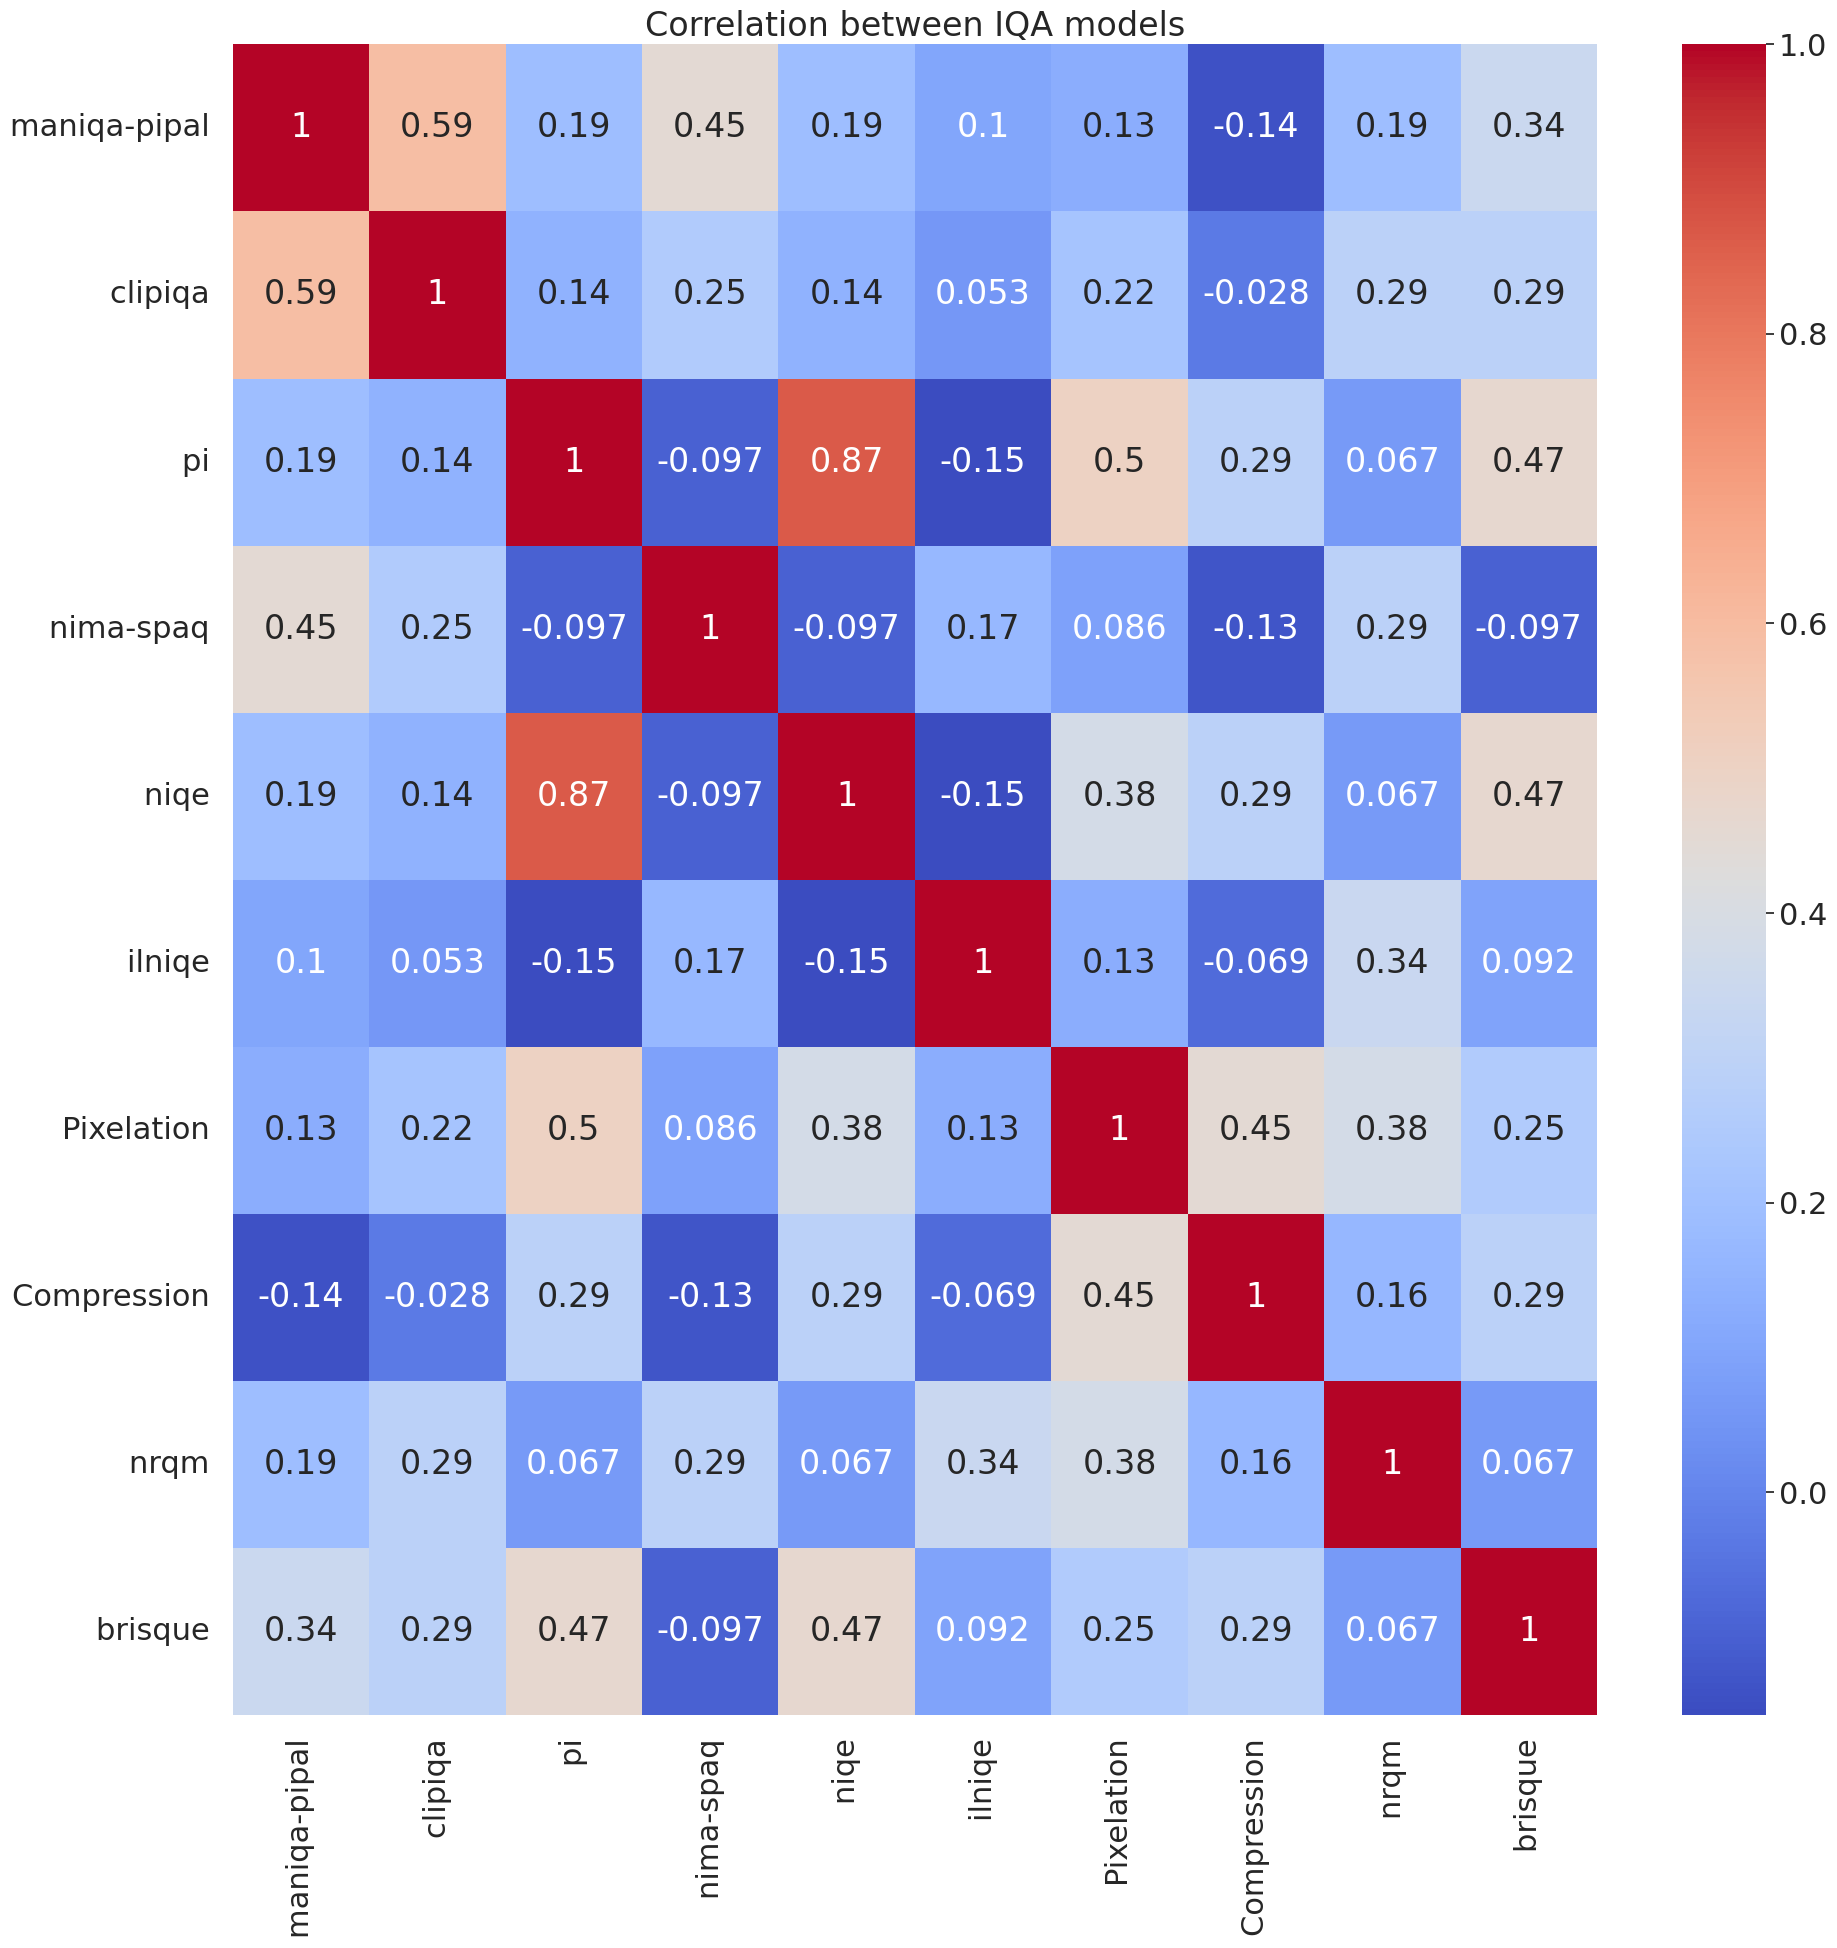

In [35]:
# plot the correlation between the scores
import seaborn as sns
import matplotlib.pyplot as plt
scores_names = []
scores_names += hits_df.groupby("labeled_quality").count().T.index.tolist()
scores_names = list(set(scores_names))
df = hits_df[scores_names]
# sort values by auc
df = df[auc_df.sort_values(by="auc", ascending=False)["metric"].values[:10]]
# remove arrows
df.columns = df.columns.str.replace("↓", "")
df.columns = df.columns.str.replace("↑", "")
correlation = df.corr()
plt.figure(figsize=(20, 20))
# increase font
sns.set(font_scale=2)
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation between IQA metrics")
plt.tight_layout()
plt.savefig("../results/auc/iqa_correlation.pdf", dpi=100)
plt.show()

# Percentile Analysis



In [5]:
iqa_df.columns

Index(['img_path', 'shape', 'labeled_quality', 'pred_compression ↓',
       'pred_pixelation ↓', 'brisque ↓', 'clipiqa ↑', 'clipiqa+ ↑',
       'clipiqa+_rn50_512 ↑', 'cnniqa ↑', 'dbcnn ↑', 'entropy ↑', 'ilniqe ↓',
       'laion_aes ↑', 'maniqa ↑', 'maniqa-kadid ↑', 'maniqa-koniq ↑',
       'maniqa-pipal ↑', 'musiq ↑', 'musiq-ava ↑', 'musiq-koniq ↑',
       'musiq-paq2piq ↑', 'musiq-spaq ↑', 'nima ↑', 'nima-koniq ↑',
       'nima-spaq ↑', 'nima-vgg16-ava ↑', 'niqe ↓', 'nrqm ↑', 'paq2piq ↑',
       'pi ↓', 'topiq_iaa ↑', 'topiq_iaa_res50 ↑', 'topiq_nr ↑',
       'topiq_nr-flive ↑', 'topiq_nr-spaq ↑', 'tres ↑', 'tres-flive ↑',
       'tres-koniq ↑', 'uranker ↑'],
      dtype='object')

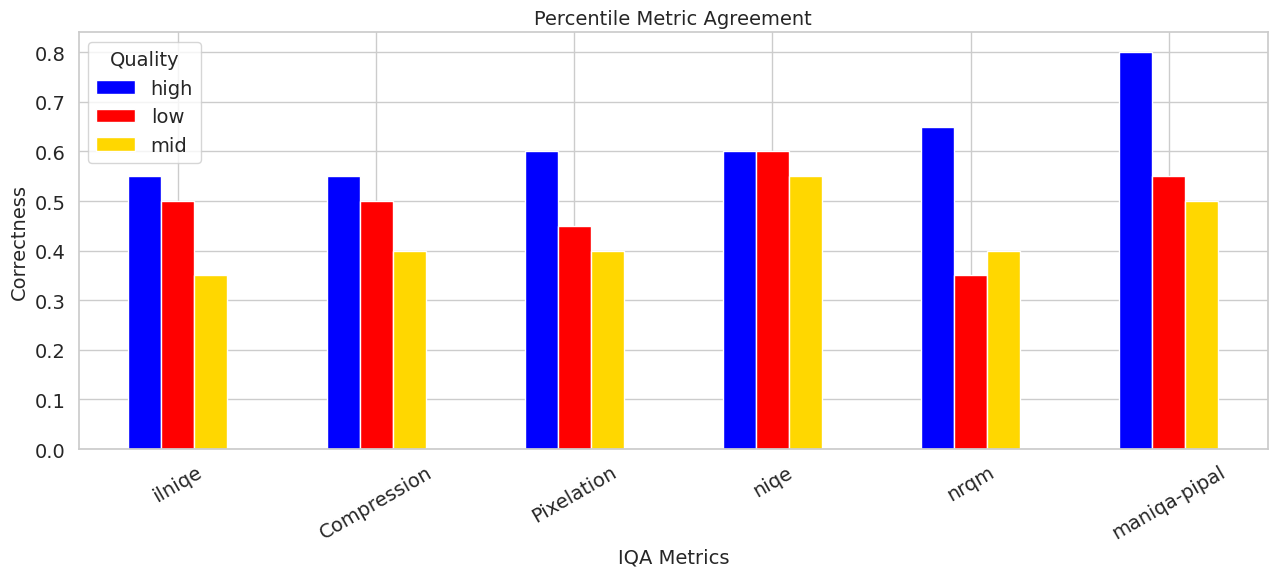

In [12]:
# Read the data
iqa_df = pd.read_csv("../results/iqa_results_with_arrows.csv")
iqa_df = iqa_df.rename(columns={ 'pred_compression ↓': "Compression ↓", 'pred_pixelation ↓': "Pixelation ↓"})
selected_metrics = ['img_path', 'shape',  "labeled_quality", 'maniqa-pipal ↑', 'niqe ↓', 'ilniqe ↓', 'Pixelation ↓', 'Compression ↓', 'nrqm ↑',]
iqa_df = iqa_df[selected_metrics]
# calculate correctness based on their percentile
correctness_df = calculate_correctness(iqa_df)
correctness_df = correctness_df.rename(columns={'labeled_quality': "Quality"})
correctness_df = correctness_df.rename(columns={x: x.replace(" ↓", "") for x in correctness_df.columns})
correctness_df = correctness_df.rename(columns={x: x.replace(" ↑", "") for x in correctness_df.columns})

# Plot the correctness of the metrics
# sns settings
fontsize =14
sns.set(rc={'figure.figsize':(20, 5), 'font.size':fontsize, 'axes.titlesize':fontsize, 'axes.labelsize':fontsize, 'xtick.labelsize':fontsize, 'ytick.labelsize':fontsize, 'legend.fontsize':fontsize, 'legend.title_fontsize':fontsize})
sns.set_style('whitegrid')
# include a black edge in the bars
# sns.set_context("paper", rc={"lines.linewidth": 2.5})

# make high quality blue, mid yellow and low red
colors = {'high': 'blue', 'mid': 'gold', 'low': 'red'}
correctness_df.groupby("Quality").mean().T.sort_values("high", ascending=True).plot(kind="bar", figsize=(13, 6), title="Percentile Metric Agreement", 
                                color=[colors[x] for x in correctness_df.groupby("Quality").mean().T.columns],
                                xlabel="IQA Metrics", ylabel="Correctness", rot=30)
# change name of the legend to Quality
plt.legend(title="Quality", loc="upper left")
plt.tight_layout()
plt.savefig("../results/percentile/iqa_correctness.pdf", dpi=100)

In [23]:
s_df.groupby("labeled_quality").mean().T.nlargest(3, quality).index

Index(['ilniqe ↓', 'niqe ↓', 'nrqm ↑'], dtype='object')

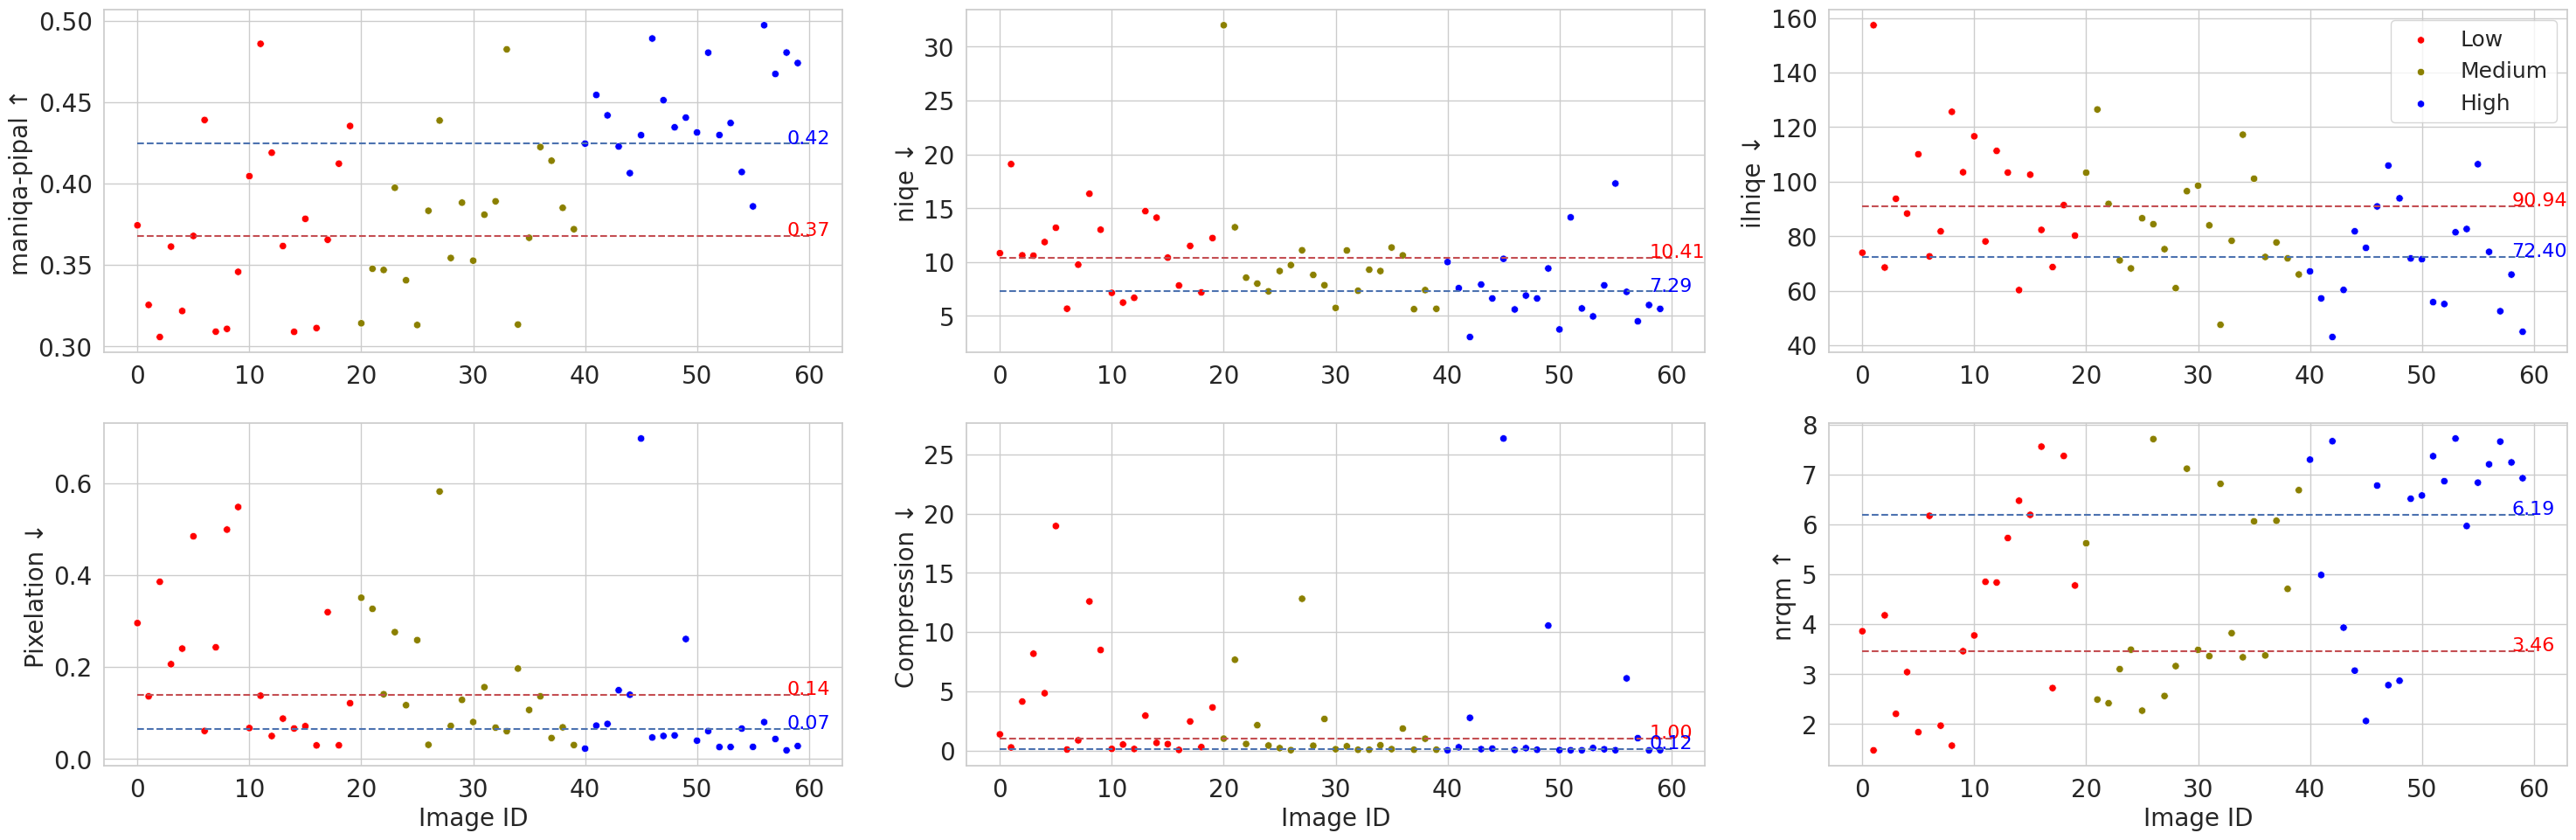

In [33]:
# plot the score of each best model painted by its quality label
iqa_df = pd.read_csv("../results/iqa_results_with_arrows.csv")
iqa_df = iqa_df.rename(columns={ 'pred_compression ↓': "Compression ↓", 'pred_pixelation ↓': "Pixelation ↓"})
selected_metrics = ['img_path', 'shape',  "labeled_quality", 'maniqa-pipal ↑', 'niqe ↓', 'ilniqe ↓', 'Pixelation ↓', 'Compression ↓', 'nrqm ↑',]
iqa_df = iqa_df[selected_metrics].copy()

low = iqa_df[iqa_df["labeled_quality"] == "low"]
mid = iqa_df[iqa_df["labeled_quality"] == "mid"]
high = iqa_df[iqa_df["labeled_quality"] == "high"]
iqa_df = pd.concat([low, mid, high], ignore_index=True)
s_df = iqa_df[["labeled_quality", 'maniqa-pipal ↑', 'niqe ↓', 'ilniqe ↓', 'Pixelation ↓', 'Compression ↓', 'nrqm ↑']].copy()

colors = {'high': 'blue', 'mid': '#8B8000', 'low': 'red'}


sns.set(rc={'figure.figsize':(20, 10), 'font.size':20, 'axes.titlesize':20, 'axes.labelsize':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 'legend.fontsize':18, 'legend.title_fontsize':20})
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))
ax = ax.flatten()
# plot the score of the best 3 models for each quality
for i, model in enumerate(['maniqa-pipal ↑', 'niqe ↓', 'ilniqe ↓', 'Pixelation ↓', 'Compression ↓', 'nrqm ↑']):
    model_scores = iqa_df[[model]]
    sns.scatterplot(data=model_scores,x=model_scores.index, y=model, color=[colors[x] for x in s_df["labeled_quality"]], ax=ax[i])
    # plot the mean of the model for each quality
    # high_mean = model_scores[iqa_df["labeled_quality"] == "high"].quantile([0.25]).values[0][0]
    # mid_mean = model_scores[iqa_df["labeled_quality"] == "mid"].quantile([0.5]).values[0][0]
    # low_mean = model_scores[iqa_df["labeled_quality"] == "low"].quantile([0.75]).values[0][0]
    threshold, _ = get_best_threshold(model)
    # if '↓' in model:
    #     threshold = -threshold

    # blot text with the mean of the model for each quality
    label=""
    if i==2:
        label="Low"
    sns.scatterplot(data=model_scores[:20], x=model_scores.index[:20], y=model, color=[colors[x] for x in s_df["labeled_quality"][:20]], ax=ax[i],
                    label=label)
    label=""
    if i==2:
        label="Medium"
    sns.scatterplot(data=model_scores[20:40], x=model_scores.index[20:40], y=model, color=[colors[x] for x in s_df["labeled_quality"][20:40]], ax=ax[i],
                    label=label,)
    label=""
    if i==2:
        label="High"
    sns.scatterplot(data=model_scores[40:], x=model_scores.index[40:], y=model, color=[colors[x] for x in s_df["labeled_quality"][40:]], ax=ax[i],
                    label=label)
    # include legend
    if i> 2:
        ax[i].set_xlabel(f"Image ID")
    else:
        ax[i].set_xlabel("")
    # plot the mean of the model for each Quality
    high_mean = model_scores.quantile([0.666], interpolation="nearest").values[0][0]
    low_mean = model_scores.quantile([0.333], interpolation="nearest").values[0][0]

    if "↑" in model:
        ax[i].plot([0, len(model_scores)], [high_mean, high_mean], 'b--')
        ax[i].text(58, high_mean, f"{high_mean:.2f}", fontsize=16, color="blue")

        ax[i].plot([0, len(model_scores)], [low_mean, low_mean], 'r--')
        ax[i].text(58, low_mean, f"{low_mean:.2f}", fontsize=16, color="red")

    else:
        ax[i].plot([0, len(model_scores)], [high_mean, high_mean], 'r--')
        ax[i].text(58, high_mean, f"{high_mean:.2f}", fontsize=16, color="red")

        ax[i].plot([0, len(model_scores)], [low_mean, low_mean], 'b--')
        ax[i].text(58, low_mean, f"{low_mean:.2f}", fontsize=16, color="blue")

    # blot text with the mean of the model for each quality
    # ax[qi, i].plot([0, len(model_scores)], [threshold, threshold], 'b--')
    # ax[qi, i].text(58, threshold, f"{threshold:.2f}", fontsize=16, color="blue")
plt.tight_layout()
plt.savefig("../results/percentile/best_iqa_scores_percentile_visualization.pdf", dpi=100)

In [ ]:
# Creates a HTML visualization of the best models
iqa_df = pd.read_csv("../results/iqa_results_with_arrows.csv")
iqa_df = iqa_df.rename(columns={ 'pred_compression ↓': "Compression ↓", 'pred_pixelation ↓': "Pixelation ↓"})
selected_metrics = ['img_path', 'shape',  "labeled_quality", 'maniqa-pipal ↑', 'niqe ↓', 'ilniqe ↓', 'Pixelation ↓', 'Compression ↓', 'nrqm ↑',]
iqa_df = iqa_df[selected_metrics].copy()
calculate_correctness(iqa_df, output_path="../results/percentile/best_results.html")
